In [159]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [160]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [161]:
### Read in observations ###
directory = "/Users/techadmin/ATMO528/ATSC528/"
filename = "RAOBs_201903131200.txt"
data_str = np.loadtxt("RAOBs_201903131200.txt", delimiter = ',', dtype = str)
# file = open(directory + filename)
# data = file.read()
latitude = data_str[:, 1].astype(float)
longitude = data_str[:, 2].astype(float)
g_h = data_str[:, 3].astype(float)

print(latitude)

[51.47 43.83 53.55 53.75 64.3  69.1  80.   68.3  63.75 48.53 82.52 51.27
 58.47 53.97 74.72 43.93 60.02 68.78 58.1  65.28 58.83 58.75 53.32 50.68
 50.22 53.9  35.05 45.45 57.75 40.35 58.68 40.17 42.75 35.23 61.17 55.03
 45.07 32.5  60.78 46.77 33.57 36.13 43.57 25.9  71.3  42.93 35.97 46.87
 55.2  41.66 32.9  27.77 37.77 39.86 29.37 32.17 39.78 29.37 42.7  41.62
 31.87 24.55 64.82 33.37 35.23 38.95 32.79 48.22 39.13 44.48 36.08 43.89
 38.95 39.43 40.15 48.57 19.72 32.32 30.5  18.43 10.58 41.13 30.12 34.73
 40.87 34.83 31.95 19.43 25.75 42.37 34.78 25.82 44.83 23.18 27.7  30.23
 32.85 24.57 33.02 37.73 41.32 35.4  40.87 64.5  47.7  66.87 35.22 40.67
 40.5  44.05 39.57 43.07 43.23 37.2   9.98 18.43 37.23 32.47 30.25 40.78
 44.92 57.16 27.7  47.46 30.4  39.07 32.12 47.95 44.07 36.05 37.93 32.37
 59.52 46.38 60.72]


In [162]:
### Set up analysis map with a 22x28 rectangular grid of points ###
phi0 = np.radians(60) #phi naught , 60N
psi0 = np.radians(90)-phi0
lambda0 = -115 #lamda naught, 115W
delx = 1.27 #cm
dely = 1.27 #cm
x0 = 18.90 #cm
y0 = -6.30 #cm 
x_range = np.arange(22)
y_range = np.arange(28)
print(x_range)
x_calculation = x0 + (delx*x_range) 
y_calculation = y0 + (dely*y_range)
rho = 6371000 #meters
map_scale = 1/15000000 #15 million

x = np.array(x_calculation)
y = np.array(y_calculation)
x_g, y_g = np.meshgrid(x,y)
print(x_g.shape) 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
(28, 22)


(28, 22)


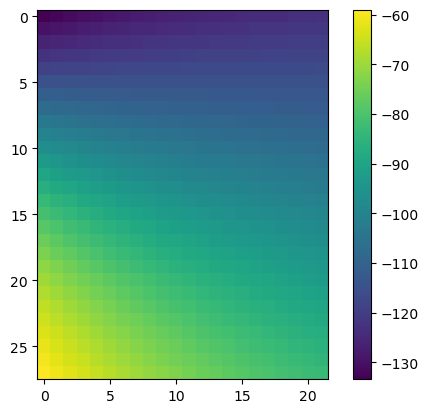

In [163]:
### convert obs lat/long to x,y ###
x_g_m = x_g/100
y_g_m = y_g/100
print(x_g_m.shape)
numer = (((((x_g_m)/map_scale)**2)+(((y_g_m)/map_scale)**2))**(1/2))
denom = rho*(1+(np.cos(psi0)))
psi = (np.pi/2) - (2*(np.arctan(numer/denom))) #x-cord, y-cord to latitude?
psi = np.degrees(psi)

lamda = (np.degrees(np.arctan(y_g_m/x_g_m)))+lambda0 #x-cord, y-cord to longitude?
# print(lamda)

# print(psi,lamda)
plt.imshow(lamda)
plt.colorbar()

In [164]:
### Create function for Cressman Analysis ###
sigma = ((1+np.sin(np.radians(60)))/(1+np.sin(np.radians(latitude))))

x_ob = rho*sigma*(np.cos(np.radians(latitude)))*(np.cos(np.radians(longitude)+np.radians(115))) #converting coords to x
y_ob = rho*sigma*(np.cos(np.radians(latitude)))*(np.sin(np.radians(longitude)+np.radians(115))) #converting coords to y
# print(y_ob.shape)
x_ob = x_ob * map_scale
y_ob = y_ob * map_scale
# print('x_ob', x_ob)
# print('y_ob', y_ob)
dmin = 0.0

for i in range(len(x_ob)):
      # distance_analysis_to_ob = np.sqrt(((x_g_m[i,j]-x_ob)**2)+((y_g_m[i,j]-y_ob)**2))
      distance_ob_to_ob = np.sqrt(((x_ob[i]-x_ob)**2)+((y_ob[i]-y_ob)**2))
      # print("with zero =",len(distance_ob_to_ob))
      distance_ob_to_ob = np.delete(distance_ob_to_ob,i)
      #distance_ob_to_ob = distance_ob_to_ob[distance_ob_to_ob>1e-10] #------------told in class that dmin = avg minimum distance between obs.
      # print("without zero =",len(distance_ob_to_ob))
      #print('distance_ob_to_ob', distance_ob_to_ob)
      #print('distance_ob_to_ob_shape', distance_ob_to_ob.min())
      dmin = dmin + np.amin(distance_ob_to_ob)   
      # print('dmin is', dmin)
      #dmin = distance_ob_to_ob.min()
      # print(temp)

dmin = dmin/len(x_ob)

dmin = dmin *100 #converting to cm?

R1 = 4*dmin
R2 = 2.5*dmin
R3 = 1.5*dmin

def cressman(R, dik):
    numerator = (R**2) - (dik**2)
    denominator = (R**2) + (dik**2)
    weight = numerator / denominator #renamed weight as something such as easier naming for later
    #print('numerator', numerator)
    #print('denominator', denominator)
    print('weight', weight)
    weight[dik>R]=0
    #print('weight', weight)
    return weight

fa = np.zeros((28,22))
for i in range(len(x_g_m)):
    for j in range(len(x_g_m[i])):
              distance_analysis_to_ob = np.sqrt(((x_g_m[i,j]-x_ob)**2)+((y_g_m[i,j]-y_ob)**2))
              dik = distance_analysis_to_ob
              print('dik',dik)
              w = cressman(R1,dik)
              print('w', w)
              fa[i,j] = np.nansum(w*g_h)/np.nansum(w)
              

print('D_min =',dmin)
print('fa', fa)
# plt.contour(fa)

dik [0.18976604 0.31961906 0.09898156 0.23463264 0.12319106 0.09895554
 0.16087451 0.04731717 0.20651054 0.31407027 0.18903315 0.22413118
 0.19792455 0.13910497 0.13363053 0.33907702 0.07791997 0.15969883
 0.23001307 0.03340855 0.04556643 0.14356107 0.27959105 0.08769591
 0.27875306 0.07249765 0.25103602 0.19791614 0.07649014 0.29544642
 0.08754796 0.22020362 0.30561678 0.26291077 0.05821539 0.05100177
 0.25490707 0.3093802  0.09968679 0.1818103  0.32811486 0.30346252
 0.16088085 0.35501021 0.09461087 0.28184589 0.29369416 0.29312424
 0.12266541 0.32080359 0.35111844 0.33794858 0.24820357 0.21821133
 0.31483715 0.26523457 0.21853421 0.31428465 0.26707474 0.25017322
 0.27744923 0.41642088 0.0519465  0.33206131 0.23704141 0.25263611
 0.29745899 0.15376558 0.2134924  0.238998   0.32671259 0.30466901
 0.31412242 0.28851989 0.2669778  0.19550116 0.37969957 0.32232047
 0.36484111 0.52794217 0.62649935 0.22092268 0.33047606 0.29587769
 0.1861318  0.29508863 0.28855791 0.41223307 0.41272047 0.

In [165]:
### Perform 500mb geopotential height analyses using a Cressman weighting Function###
#Use radii of influence 4, 2.5, 1.5 *dmin
# print('dmin', dmin)
# print('dik', dik)

cressman_1 = cressman(R1, dik)
cressman_2 = cressman(R2, dik)
cressman_3 = cressman(R3, dik)

print('cressman_1', cressman_1)

weight [0.99868881 0.99893938 0.99782872 0.99847092 0.99751463 0.99690128
 0.99585853 0.99609041 0.99752925 0.99837281 0.9954709  0.99873646
 0.99812834 0.99828283 0.99644701 0.99868195 0.99748519 0.99714361
 0.99802304 0.99653775 0.99710726 0.99804728 0.9981549  0.99717347
 0.99855886 0.99733942 0.9990321  0.99892952 0.99521404 0.99944429
 0.99490905 0.99902467 0.99918639 0.99928128 0.99539871 0.99675245
 0.99917809 0.99966899 0.99457419 0.99877785 0.99976606 0.99965336
 0.99816714 0.99967139 0.99497938 0.99928762 0.99962039 0.99882906
 0.99430595 0.9991853  0.99977867 0.99964562 0.99926447 0.99896845
 0.99947516 0.99881746 0.99896692 0.99946528 0.99932547 0.99933293
 0.99909685 0.99998274 0.99550199 0.99977609 0.99869605 0.99935825
 0.99956257 0.99846845 0.99879674 0.99919422 0.99965233 0.99907162
 0.99948902 0.99950723 0.99943884 0.99885176 0.9922084  0.99975625
 0.99986756 0.99943667 0.99871484 0.99908771 0.99974728 0.99962593
 0.99838747 0.99962208 0.99934881 0.99956611 0.99995069

In [166]:
### First analysis, no successive corrections ###
analysis_1 = np.sum(w*dik*g_h)/(np.sum(w*dik))
print(analysis_1)

5442.61896111529


In [167]:
### Create function for bilinear interpolation ###
def bilienar_interp(x_ob, y_ob, x_g_m, y_g_m):
    x_k = x_ob*100
    y_k = y_ob*100
    index_x = ((x_k - x0) / delx)
    index_y = ((y_k - y0) / dely)

    #flip x,y to j,i because rows then columns in python
    BLindex_j = int(np.floor(index_x))
    BLindex_i = int(np.floor(index_y))

    print(BLindex_i,BLindex_i+2)
    four_xs = x_g_m[BLindex_i:BLindex_i+2,BLindex_j:BLindex_j+2]
    four_ys = y_g_m[BLindex_i:BLindex_i+2,BLindex_j:BLindex_j+2]
    four_ghs = analysis_1[BLindex_i:BLindex_i+2,BLindex_j:BLindex_j+2]

    dxk = x_ob - four_xs
    dyk = y_ob - four_ys

    # print(four_ghs)

    a_matrix = ([1, np.mean(dxk), np.mean(dyk), np.mean(dxk*dyk)],
             [np.mean(dxk), np.mean(dyk**2), np.mean(dxk*dyk), np.mean((dxk**2)*dyk)]
             [np.mean(dyk), np.mean(dxk*dyk), np.mean(dyk**2), np.mean(dxk*(dyk**2))]
             [np.mean(dxk*dyk), np.mean((dxk**2)*dyk), np.mean(dxk*(dyk**2)), np.mean((dxk**2)(dyk**2))])
    
    b_matrix = ([analysis_1,
                 np.mean(dxk),
                 np.mean(dyk),
                 np.mean(dxk*dyk)])

    coef = np.linalg.inv(a_matrix)*b_matrix

    BLvalue = g_h[BLindex_j, BLindex_i]
    return 

test = bilienar_interp(x_ob[0], y_ob[0], x_g_m, y_g_m)
print (test)

14 16


<>:23: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:23: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
/var/folders/ph/gnz9scgj5491zgp3rggx75kr0000gp/T/ipykernel_866/3403980656.py:23: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [np.mean(dxk), np.mean(dyk**2), np.mean(dxk*dyk), np.mean((dxk**2)*dyk)]
/var/folders/ph/gnz9scgj5491zgp3rggx75kr0000gp/T/ipykernel_866/3403980656.py:23: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [np.mean(dxk), np.mean(dyk**2), np.mean(dxk*dyk), np.mean((dxk**2)*dyk)]
/var/folders/ph/gnz9scgj5491zgp3rggx75kr0000gp/T/ipykernel_866/3403980656.py:23: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [np.mean(dxk), np.mean(dyk**2), np.mean(dxk*dyk), np.mean((dxk**2)*dyk)]


IndexError: invalid index to scalar variable.

In [ ]:
### Next Analyses ###
f_aj = analysis_1 + np.sum(something*dik(fo-fa))

In [ ]:
### Calculate Analysis Differences
f_a_diff = f_aj - analysis_1

In [ ]:
### Plot 500mb analyses over a map ###
#use old code...

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,analysis_10[:,:],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.show()

#for roi20
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,analysis_20[:,:],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.show()

In [ ]:
### Plot Analysis Differences ###


In [ ]:
### Store the analyses in text files ###
with open('analyses_10cm.txt','wb') as f:
    for line in analysis_10:
        np.savetxt(f, line, fmt='%.2f')

with open('analyses_20cm.txt','wb') as f:
    for line in analysis_20:
        np.savetxt(f, line, fmt='%.2f')


In [ ]:
### Store the difference fields in text files ###
with open('analyses_10cm.txt','wb') as f:
    for line in analysis_10:
        np.savetxt(f, line, fmt='%.2f')

with open('analyses_20cm.txt','wb') as f:
    for line in analysis_20:
        np.savetxt(f, line, fmt='%.2f')


In [ ]:
### Store RMS values in text file ###
with open('analyses_10cm.txt','wb') as f:
    for line in analysis_10:
        np.savetxt(f, line, fmt='%.2f')

with open('analyses_20cm.txt','wb') as f:
    for line in analysis_20:
        np.savetxt(f, line, fmt='%.2f')


In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    

3 - What happens as you increase the number of successive correction passes?  Is this 
    desirable?  Why or why not?
    

'''